Step 1) Functions for creating spectrograms and PNGs from WAV files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
%matplotlib inline

# Check if CUDA is available
use_cuda = True
if not os.environ.get("CUDA_VISIBLE_DEVICES"):
    use_cuda = False

if use_cuda:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU device index you want to use
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Set to an empty string to use CPU

print(os.environ["CUDA_VISIBLE_DEVICES"])

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

Step 2) Converting wav to pngs and saving images as x and labels as y (0 is clean and noisy is 1)

In [ ]:
create_pngs_from_wavs('dataset_classification2/clean', 'Spectrograms/clean')

In [2]:
create_pngs_from_wavs('dataset_classification2/noisy', 'Spectrograms/noisy')

In [2]:
from keras.utils import load_img, img_to_array

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(img_to_array(load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

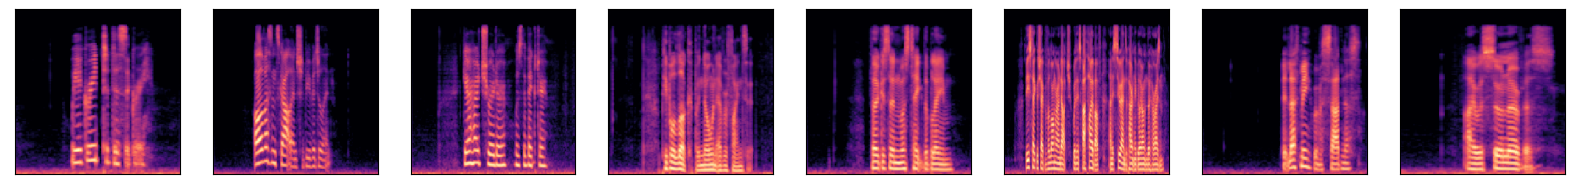

In [3]:
images, labels = load_images_from_path('Spectrograms/clean', 0)
show_images(images)
    
x += images
y += labels

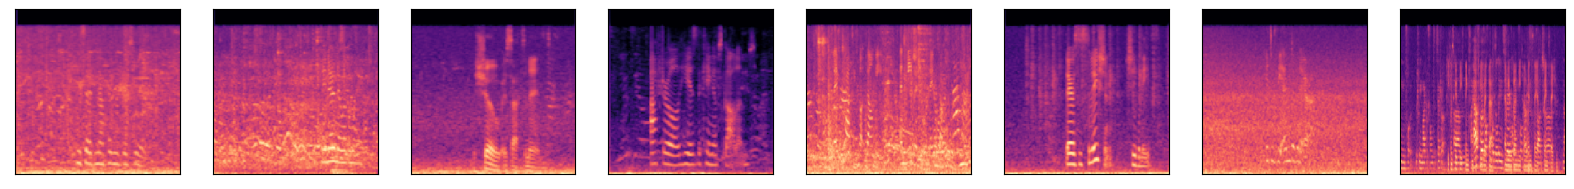

In [4]:
images, labels = load_images_from_path('Spectrograms/noisy', 1)
show_images(images)
    
x += images
y += labels

Step 3) Spliting the dataset into training and testing 80/20, respectively 

In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Step 4) Training the model with a batch size and epoch number of 10

In [7]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
120/120 [==============================] - 66s 547ms/step - loss: 0.1085 - accuracy: 0.9600 - val_loss: 0.0539 - val_accuracy: 0.9900
Epoch 2/10
120/120 [==============================] - 67s 556ms/step - loss: 0.0261 - accuracy: 0.9950 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/10
120/120 [==============================] - 63s 527ms/step - loss: 0.0210 - accuracy: 0.9958 - val_loss: 0.0073 - val_accuracy: 0.9967
Epoch 4/10
120/120 [==============================] - 63s 529ms/step - loss: 0.0232 - accuracy: 0.9958 - val_loss: 0.0442 - val_accuracy: 0.9900
Epoch 5/10
120/120 [==============================] - 63s 522ms/step - loss: 0.0197 - accuracy: 0.9975 - val_loss: 0.0230 - val_accuracy: 0.9933
Epoch 6/10
120/120 [==============================] - 59s 489ms/step - loss: 0.0225 - accuracy: 0.9983 - val_loss: 7.1163e-04 - val_accuracy: 1.0000
Epoch 7/10
120/120 [==============================] - 64s 536ms/step - loss: 0.0303 - accuracy: 0.9933 - val_loss: 0.0154 - va

Step 5) Evaluation

[]

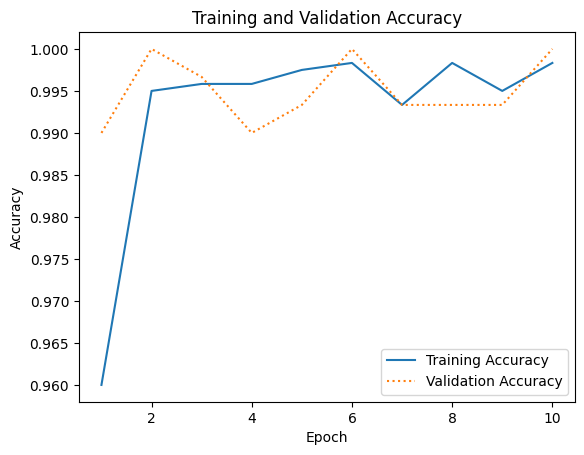

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

10/10 [==============================] - 3s 249ms/step


Text(110.44999999999997, 0.5, 'Actual label')

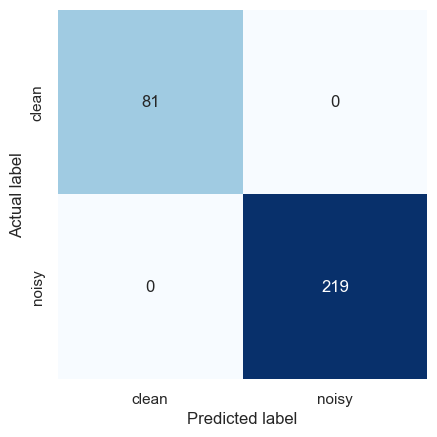

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(x_test_norm)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['clean', 'noisy']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Step 6) Saving and loading model

In [10]:
model.save('models/my_model.h5')

In [11]:
import tensorflow as tf

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('models/my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [12]:
# Evaluate the model on the test data
loss, accuracy = new_model.evaluate(x_test_norm, y_test_encoded)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 3s 238ms/step - loss: 3.2191e-04 - accuracy: 1.0000
Test Loss: 0.00032191415084525943
Test Accuracy: 1.0


Step 7) Testing model with test_dataset

In [13]:
create_pngs_from_wavs('dataset_test/clean', 'Spectrograms/test/clean')

In [14]:
create_pngs_from_wavs('dataset_test/noisy', 'Spectrograms/test/noisy')

In [15]:
test_images_clean, test_labels_clean = load_images_from_path('Spectrograms/test/clean', 0)
test_images_noisy, test_labels_noisy = load_images_from_path('Spectrograms/test/noisy', 1)

test_images = test_images_clean + test_images_noisy
test_labels = test_labels_clean + test_labels_noisy


In [16]:
x_test = np.array(test_images) / 255
y_test = to_categorical(test_labels)


In [17]:
loss, accuracy = new_model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 21s 324ms/step - loss: 0.0135 - accuracy: 0.9980
Test Loss: 0.013528690673410892
Test Accuracy: 0.9980000257492065


63/63 [==============================] - 19s 307ms/step


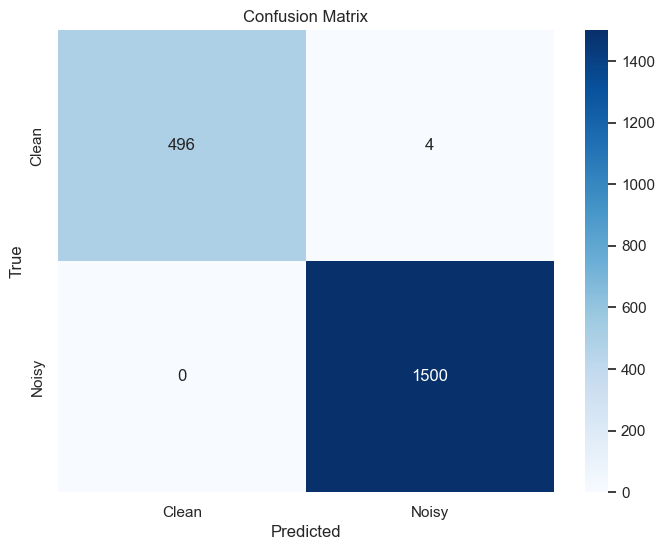

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the predictions for the test data: y_pred
y_pred = new_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)

# Create a list of class labels
class_labels = ['Clean', 'Noisy']  # Update with your actual class labels

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


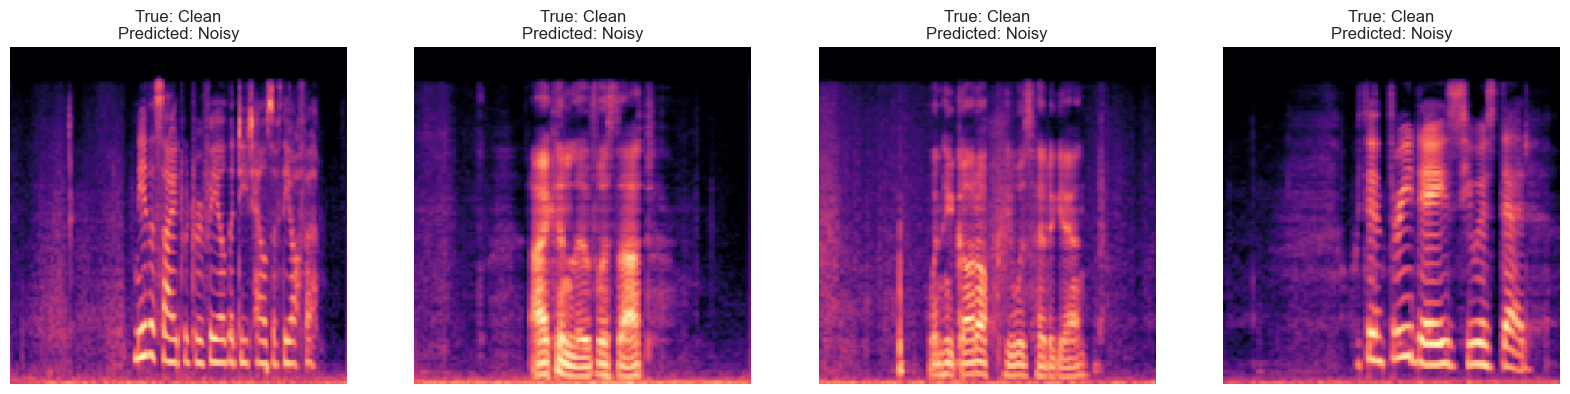

In [24]:
incorrect_indices = np.where(y_pred_labels != np.argmax(y_test, axis=1))[0]

num_incorrect = len(incorrect_indices)
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_incorrect + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
fig.subplots_adjust(hspace=0.5)

axes = axes.ravel()  # Reshape the axes array into a 1-dimensional array

for i, index in enumerate(incorrect_indices):
    spectrogram_image = x_test[index]
    true_label = class_labels[np.argmax(y_test[index])]
    predicted_label = class_labels[y_pred_labels[index]]

    ax = axes[i]
    ax.imshow(spectrogram_image)
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.show()
